# Modelación de tópicos
---

In [3]:
import time, re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

## Web scrapping
---

In [4]:
# Define numero aleatorios entre 3 y 7
def distriProb_lognorm():
  pdf = np.random.lognormal(mean=2.0, sigma=0.5, size=(1))
  if pdf<3  or pdf>7:
    pdf=np.random.randint(3,6)
  return float(pdf)

In [6]:
# Define el nevegador
options = webdriver.ChromeOptions()
#options.add_argument('--headless')
#options.add_argument('--no-sandbox')
#options.add_argument('--disable-dev-shm-usage')
chrome_driver = "./chromedriver"
options.binary_location = "/usr/bin/google-chrome-stable"
webpage_target = 'https://www.sciencedirect.com/'
driver = webdriver.Chrome(options = options)

In [72]:
# Colocamos el link de la pagina donde queremos hacer la busqueda
try:
    driver.get(webpage_target)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(distriProb_lognorm())
    driver.refresh()
    driver.get(webpage_target)

In [73]:
# Enviamos un query de busqueda a la barra de busqueda
search_box_id = 'qs'
query = 'eddies'
search_box = driver.find_element(By.ID, search_box_id)
search_box.send_keys(query)
search_box.send_keys(Keys.RETURN) #click enter

In [74]:
# Filtramos los resultados por los que corresponden a reviewa
try:
    time.sleep(distriProb_lognorm())
    reviews = driver.find_element(By.ID, "articleTypes-REV")
    driver.execute_script("arguments[0].click();", reviews)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(10)
    driver.refresh()
    reviews = driver.find_element(By.ID, "articleTypes-REV")
    driver.execute_script("arguments[0].click();", reviews)
try:
    time.sleep(distriProb_lognorm())
    earth = driver.find_element(By.ID, "subjectAreas-1900")
    driver.execute_script("arguments[0].click();", earth)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(10)
    driver.refresh()
    time.sleep(10)
    show_more = driver.find_element(By.CSS_SELECTOR, '[aria-label="Show more subjectAreas filters"]')
    driver.execute_script("arguments[0].click();", show_more)
    time.sleep(distriProb_lognorm())
    earth = driver.find_element(By.ID, "subjectAreas-1900")
    driver.execute_script("arguments[0].click();", earth)

Hubo un error de conexion intentando de nuevo...


In [75]:
# Definimos 100 articulos por pagina
time.sleep(distriProb_lognorm())
xpath_100 = "//a[@class='anchor' and @data-aa-name='srp-100-results-per-page']"
first_100 = driver.find_element(By.XPATH, xpath_100)
driver.execute_script("arguments[0].click();", first_100)

/tmp/ipykernel_11566/140653954.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pdf)


In [76]:
# Extreamos el html
time.sleep(distriProb_lognorm())
soup = BeautifulSoup(driver.page_source, 'html.parser')
art_html = soup.find_all('a', 'anchor result-list-title-link u-font-serif text-s anchor-default', 'rev')
pages_html = soup.find(id="srp-pagination")
n_pg = re.findall(r'Page\s\d of\s(\d+)', str(pages_html))[0]
link_list = [link.get('href') for link in art_html]
# Itera sobre cada pagina de los resultados de busqueda
for _ in range(int(n_pg)-1):
    # Siguiente pagina
    time.sleep(distriProb_lognorm())
    xpath_next = "//a[@class='anchor' and @data-aa-name='srp-next-page']"
    next_100 = driver.find_element(By.XPATH, xpath_next)
    driver.execute_script("arguments[0].click();", next_100)
    # Extreamos el html
    time.sleep(distriProb_lognorm())
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    art_html = soup.find_all('a', 'anchor result-list-title-link u-font-serif text-s anchor-default', 'rev')
    # Extreamos el link del html
    next_link_list = [link.get('href') for link in art_html]
    # Se añade a una lista
    link_list.extend(next_link_list)
    print(len(link_list))

200
300


/tmp/ipykernel_11566/140653954.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pdf)


400
500
600
700
800
900
1000
1019


In [77]:
df = pd.DataFrame({'link': link_list})
df['link'] = df['link'].map(lambda link: 'https://www.sciencedirect.com'+link)
# abstracts = []
# titles = []
titles_abstracts = {}
for link in df['link']:
    #driver = webdriver.Chrome(executable_path = chrome_driver, options = options)
    time.sleep(distriProb_lognorm())
    driver.get(link)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    html_title = soup.find_all('span', 'title-text')
    title_text = re.findall(r"(?<=\>).+(?=<)", str(html_title))
    # titles.extend(title_text)
    rexp = re.compile(r"(?<=\d\"\>)\w[A-Za-z\s$&+,:;=?@#|'.^*()%!-’]+\.")
    html_abstract = soup.find_all('div', 'abstract author')
    abstract_text = re.findall(rexp, str(html_abstract))
    # abstracts.extend(abstract_text)
    print(len(titles_abstracts), end='\r')
df['titles'] = titles_abstracts.keys()
df['abstracts'] = titles_abstracts.values()
df.to_csv('abstract_pln.csv')

/tmp/ipykernel_11566/140653954.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pdf)


ValueError: Length of values (674) does not match length of index (1019)

## Preprocesamiento
---

In [96]:
import nltk
from nltk.probability import FreqDist

In [91]:
# Creamos nuestro corpus
corpus = abstracts

In [93]:
# Definimos el tokenizador
wpt = nltk.WordPunctTokenizer()
# Definimos las stopwords
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['review', 'highlight', 'highlights', 'research', 'study', 'studies', 'also'])

# Definimos el preprocesamiento
def preprocess(doc):
    # Se eliminan caracteres especiales
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    # Se convierten los téxtos a minúsculas
    doc = doc.lower().strip()
    tokens = wpt.tokenize(doc)
    # Se eliminan las stopwords
    tokens = [token for token in tokens
              if token not in stop_words and len(token) > 2]
    # Retornamos una versión filtrada del texto
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /home/mofoko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
# Preprocesamos el texto
norm_corpus = list(map(preprocess, corpus))
norm_corpus[0]

'presents overview oceanic mesoscale eddies influence overlying atmosphere surrounding waters focus southwestern atlantic ocean high values eddy kinetic energy eke region related mesoscale eddies observed transport dynamic thermodynamic specific properties away origin point life cycle transport capacity interferes several atmospheric oceanic processes local marine atmospheric boundary layer mabl stability heat fluxes primary production southern hemisphere cyclonic anticyclonic eddies related clockwise counterclockwise circulation negative positive anomalies sea surface temperature sst latent sensible heat fluxes observed clockwise cold counterclockwise warm eddies decrease increase nearsurface wind well stable unstable conditions mabl vertical downward upward movements atmosphere decreased increased precipitation sst anomalies influence curl divergence magnitude surface wind wind stress mesoscale surface oceanic currents mainly affect stress wind curls atmospheric response sst anomalie

## EDA
---

In [140]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 10.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.1/389.1 kB 8.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 11.0 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=24068763 sha256=ecc93a2511f82d93e1ef0726bfd7da87114af028d9b57444fb2cf3eefae111b9
  Stored in directory: /home/mofoko/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim


In [124]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

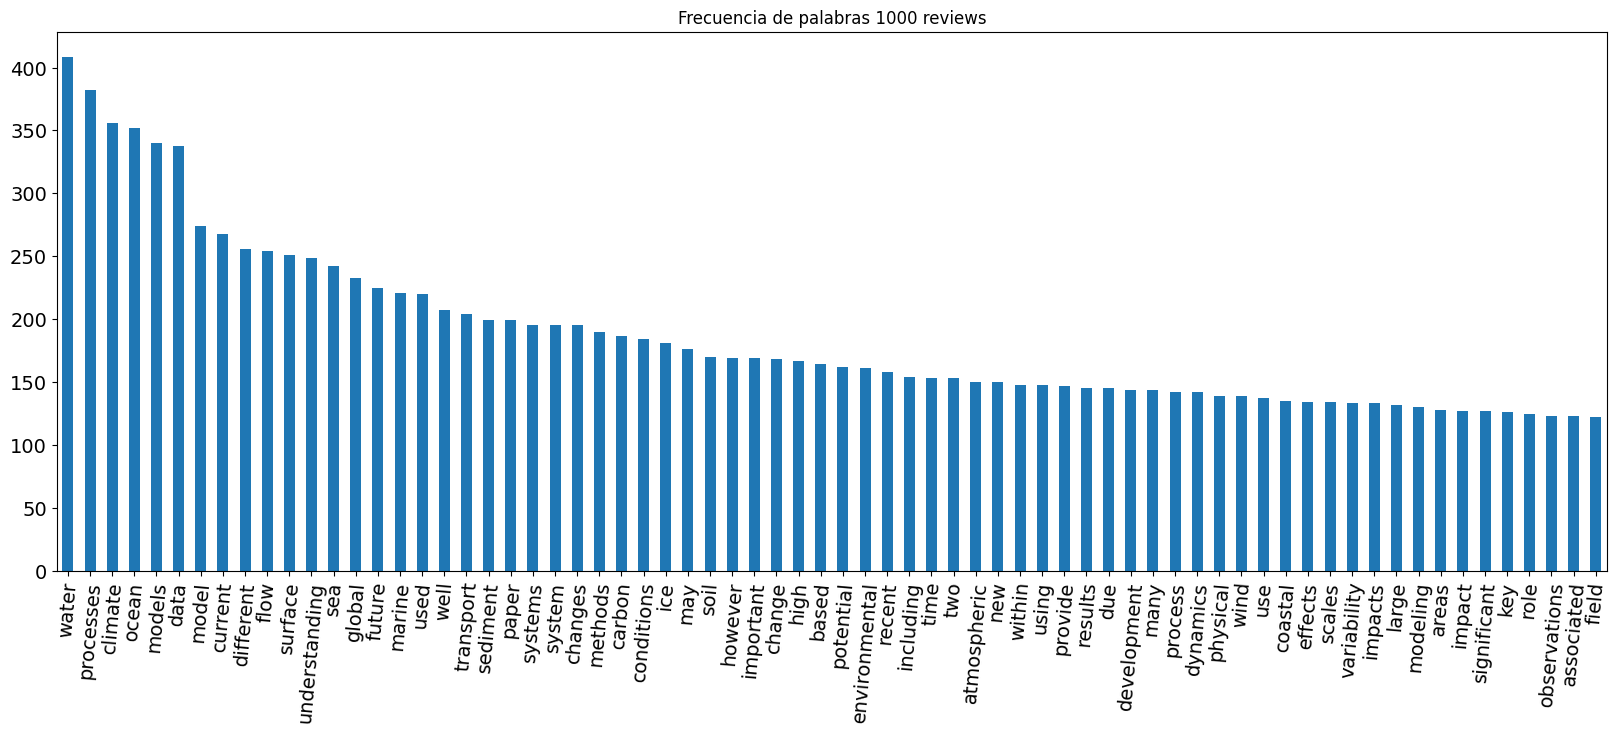

In [101]:
# Definimos el tokenizador
tokenizer = nltk.WordPunctTokenizer()
# Toquenizamos por palabra
word_tokens = tokenizer.tokenize(' '.join(norm_corpus))
# Creamos un grafico de frecuencias de palabras
frec_words = FreqDist(word_tokens)
fig = plt.figure(figsize =(20, 7))
pd.Series(dict(frec_words)).sort_values(ascending=False)[:70].plot(kind='bar', rot=85, fontsize=14, 
                                                                 title='Frecuencia de palabras 1000 reviews');

In [102]:
# Unimos el corpus en un string
long_string = ','.join(norm_corpus)
# Creamos un objeto wordcloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generamos una wordcloud
wordcloud = wordcloud.generate(long_string)
# Visualizamos el wordcloud
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

In [109]:
# Matriz de bolsa de documentos
def feature_extraction(corpus):
    bow = CountVectorizer(
        max_df=0.5
        )
    bow.fit(corpus)
    X_bow = bow.transform(corpus).toarray()
    return X_bow, bow 

In [114]:
# Bolsa de palabras
X_bow, bow = feature_extraction(norm_corpus)
X_bow.shape

(674, 12555)

In [134]:
lda = LatentDirichletAllocation(
    n_components=20,
    doc_topic_prior=1 / 20,
    topic_word_prior=1 / 20,
    random_state=42,
    ).fit(X_bow)

In [136]:
features_lda = lda.transform(X_bow)
print(features_lda.shape)

(674, 20)


In [139]:
# Listamos los topicos encontrados junto con los palabras mas fecuentes
terms = bow.get_feature_names_out()
for i, comp in enumerate(lda.components_):
    # Juntamos los términos con cada uno de los valores en la matriz V
    terms_comp = zip(terms, comp)
    # Ordenamos los términos de acuerdo al resultado de LSA
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    # Mostramos los términos más importantes en cada tópico
    print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

Tópico 0: flow patterns wind deposits velocity different waste fluid horizontal however
Tópico 1: transport sediment flow model processes scales paper current water fluid
Tópico 2: processes modeling water forest strait tsunami knowledge understanding seepage tidal
Tópico 3: methods water ocean ophiolites processes waves sciencedirects classtopiclink titlelearn aigenerated
Tópico 4: recycling process waste current materials gas dust models material global
Tópico 5: water cosubsub ocean processes drinking organic data treatment experiments surface
Tópico 6: section processes microplastics water development sif des within system cloud
Tópico 7: climate change ocean sediment sea changes processes flow region current
Tópico 8: models water processes data numerical used atmospheric climate ice understanding
Tópico 9: models ice model ocean sea climate modelling data global surface
Tópico 10: ocean processes sea oxygen marine air water ree change due
Tópico 11: dust climate river global chan

In [147]:
import pyLDAvis
import pyLDAvis.lda_model as sklearn_lda
import pickle

In [145]:
# Visualizamos lo topicos encontrados
pyLDAvis.enable_notebook()
LDAvis_data_filepath = "./ldavis_prepared"

In [148]:
X_bow = bow.transform(norm_corpus)
LDAvis_prepared = sklearn_lda.prepare(lda, X_bow, bow)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

/home/mofoko/anaconda3/envs/webscrapy/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/mofoko/anaconda3/envs/webscrapy/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/mofoko/anaconda3/envs/webscrapy/lib/python3.12/site-packages/joblib/_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
/home/mofoko/anaconda3/envs/webscrapy/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/mofoko/anaconda3/envs/webscrapy/lib/python3.12/site-packages/joblib/_utils.py:39: Dep

In [149]:
with open(LDAvis_data_filepath,"rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, "./ldavis_prepared.html")
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.078353  0.005342       1        1  8.753590
14     0.048319 -0.005301       2        1  7.921191
9      0.059577 -0.010050       3        1  7.879702
8      0.019427 -0.026786       4        1  6.637085
7      0.078860 -0.042561       5        1  6.560624
18     0.010959  0.049297       6        1  6.397576
1     -0.009074 -0.070168       7        1  5.943659
17    -0.017401 -0.042708       8        1  5.642455
11     0.072571 -0.024133       9        1  5.567393
3      0.006360  0.059850      10        1  5.368953
13     0.026340 -0.066194      11        1  4.460900
6     -0.021804  0.017005      12        1  4.080444
10     0.009429  0.006042      13        1  3.772267
2     -0.017116 -0.048314      14        1  3.435043
5     -0.102895  0.120361      15        1  3.256457
19    -0.033060 -0.011174      16        1  3.106857
12     0.010289  0.085965      17        1  3.098907
15     0.013956  0.012266      18        1  2.844352
0     -0.182930 -0.116858      19        1  2.817111
4     -0.050159  0.108119      20        1  2.455434, topic_info=            Term        Freq       Total Category  logprob  loglift
4369        flow  222.000000  222.000000  Default  30.0000  30.0000
7803       ocean  311.000000  311.000000  Default  29.0000  29.0000
10492       soil  151.000000  151.000000  Default  28.0000  28.0000
1716     climate  317.000000  317.000000  Default  27.0000  27.0000
3302        dust   73.000000   73.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8929   processes    7.959505  337.082595  Topic20  -5.6284  -0.0391
7803       ocean    6.769931  311.167805  Topic20  -5.7903  -0.1210
7207       model    6.713098  244.082483  Topic20  -5.7987   0.1134
8218       paper    6.601039  175.589315  Topic20  -5.8155   0.4259
2938   different    6.591431  226.554361  Topic20  -5.8170   0.1697

[1477 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
0         14  0.789394       aabw
1          6  0.160788  abandoned
1          8  0.643154  abandoned
12         3  0.119374   ablation
12         4  0.119374   ablation
...      ...       ...        ...
12547     15  0.040957       zone
12547     16  0.054609       zone
12547     17  0.027305       zone
12547     19  0.040957       zone
12547     20  0.054609       zone

[5440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 15, 10, 9, 8, 19, 2, 18, 12, 4, 14, 7, 11, 3, 6, 20, 13, 16, 1, 5])